In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import scipy.stats as stats
import matplotlib.pyplot as plt
from numpy import random

import particles
import particles.state_space_models as ssm
import particles.distributions as dists
from particles import collectors
from particles import multiSMC
import particles.mcmc as mcmc
import particles.smc_samplers as ssp
from functools import partial

## Data & Model

Let's take the same data and SVCJ model as before

In [4]:
SP500_TICKER = '^GSPC'
FRED_TICKER = 'DTB3'

start_date = '1996-01-01'
end_date = '2015-12-31'

Trad_days_year = 252

In [5]:
data_SP500 = yf.download(SP500_TICKER, start=start_date, end=end_date, progress=False)
rf_data = web.DataReader(FRED_TICKER, 'fred', start=start_date, end=end_date)

In [6]:
data_SP500 = data_SP500[['Close']]
data_SP500.columns = ['S_t']
data_SP500['R_t'] = np.log(data_SP500['S_t']/data_SP500['S_t'].shift(1))#log-return
data_SP500

,S_t,R_t
Date,,
1996-01-02,620.729980,NaN
1996-01-03,621.320007,0.000950
1996-01-04,617.700012,-0.005843
1996-01-05,616.710022,-0.001604
1996-01-08,618.460022,0.002834
...,...,...
2015-12-23,2064.290039,0.012342
2015-12-24,2060.989990,-0.001600
2015-12-28,2056.500000,-0.002181


In [7]:
rf_data['DTB3'] = rf_data['DTB3'].fillna(method='ffill')
rf_data.loc['1996-01-01 00:00:00','DTB3'] = rf_data.loc['1996-01-02 00:00:00','DTB3']
rf_data.columns = ['rf_t']
rf_data['rf_t'] = rf_data['rf_t']/(100)#get rid of % #252 ?
data_return_based = pd.merge(rf_data, data_SP500, left_index=True, right_index=True, how='inner')
data_return_based = data_return_based.dropna()

C:\Users\senau\AppData\Local\Temp\ipykernel_5292\2996484134.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rf_data['DTB3'] = rf_data['DTB3'].fillna(method='ffill')


In [8]:
data_y = data_return_based['R_t'].values
r_vector = data_return_based['rf_t'].values
dt = 1/252.0

In [9]:
class SVCJ_Transition:
    def __init__(self, V_prev, dt, params):
        self.V_prev = V_prev
        self.dt = dt
        self.p = params

    def rvs(self, size=None):
        N = len(self.V_prev)
        dt, p = self.dt, self.p

        # 1. Shocks (Appendix B - Step 1)
        w = np.random.normal(size=N)
        prob_jump = np.clip(p.lbd * dt, 1e-12, 1.0 - 1e-12)
        B = np.random.binomial(1, prob_jump, size=N)
        J_v = np.random.exponential(scale=p.mu_v, size=N)
        # Js correlation via rho_j (Note 33)
        J_s = np.random.normal(loc=p.mu_s + p.rho_j * J_v, scale=p.sigma_s, size=N)

        # 2. Variance Dynamics (Equation 7 - Euler Scheme)
        v_safe = np.maximum(self.V_prev, 1e-12)
        mean_rev = p.kappa * (p.theta - self.V_prev) * dt
        # dW_t = w * sqrt(dt)
        diffusion = p.sigma * np.sqrt(v_safe * dt) * w 
        jump_vol = J_v * B

        V_next = self.V_prev + mean_rev + diffusion + jump_vol

        # 3. Augmented State [V, w, Jv, B, Js]
        res = np.zeros((N, 5))
        res[:, 0] = np.maximum(V_next, 1e-12)
        res[:, 1] = w
        res[:, 2] = J_v
        res[:, 3] = B
        res[:, 4] = J_s
        return res

class SVCJ_Observation:
    def __init__(self, xp, x, r_f_t, dt, params):
        # xp is None at t=0
        self.xp = x if xp is None else xp 
        self.x = x
        self.r_f_t = r_f_t # Risk-free rate for the current period
        self.dt = dt
        self.p = params

        # Jump compensator mu_bar_s (Equation B.3)
        num = np.exp(params.mu_s + 0.5 * params.sigma_s**2)
        den = 1.0 - params.rho_j * params.mu_v
        self.mu_bar_s = (num / den) - 1.0

    def _compute_moments(self):
        p, dt = self.p, self.dt

        # Indices: 0:V, 1:w, 2:Jv, 3:B, 4:Js
        v_prev = self.xp[:, 0]
        w_curr = self.x[:, 1]
        b_curr = self.x[:, 3]
        js_curr = self.x[:, 4]

        v_safe = np.maximum(v_prev, 1e-12)

        # 1. Drift according to Equation 6 (B.3)
        # Using the specific risk-free rate r_f_t
        drift = (self.r_f_t - p.delta - 0.5 * v_safe + p.eta_s * v_safe - p.lbd * self.mu_bar_s) * dt
        
        # 2. Conditional Mean (Leverage rho included via w_curr)
        mean_cond = drift + p.rho * np.sqrt(v_safe * dt) * w_curr + b_curr * js_curr
        
        # 3. Conditional Volatility (Idiosyncratic)
        vol_cond = np.sqrt(np.maximum(v_safe * dt * (1.0 - p.rho**2), 1e-12))

        return mean_cond, vol_cond

    def logpdf(self, y_obs):
        mean_cond, vol_cond = self._compute_moments()
        return np.nan_to_num(stats.norm.logpdf(y_obs, loc=mean_cond, scale=vol_cond), nan=-1e5)

    def rvs(self, size=None):
        mean_cond, vol_cond = self._compute_moments()
        return stats.norm.rvs(loc=mean_cond, scale=vol_cond, size=size)

class SVCJ_Model(ssm.StateSpaceModel):
    def __init__(self, r_vec, dt=1/252.0, **kwargs):
        super().__init__(**kwargs)
        self.r_vec = r_vec # Risk-free rates vector
        self.dt = dt
        self.dim = 5 # V, w, Jv, B, Js

        for key, value in kwargs.items():
            setattr(self, key, value)

    def PX0(self):
        return dists.IndepProd(
            dists.LogNormal(np.log(self.theta), 0.1),
            dists.Dirac(0.0), # w
            dists.Dirac(0.0), # Jv
            dists.Dirac(0.0), # B
            dists.Dirac(0.0)  # Js
        )

    def PX(self, t, xp):
        return SVCJ_Transition(V_prev=xp[:, 0], dt=self.dt, params=self)

    def PY(self, t, xp, x):
        # We pass the risk-free rate r_vec[t] to the observation
        return SVCJ_Observation(xp=xp, x=x, r_f_t=self.r_vec[t], dt=self.dt, params=self)

## O MCMC

We have implemented O-MCMC by combining parallel PMMH chains with a population-based interaction mechanism, structured as follows:

* **Population Initialization:** Instantiate a population of Z=10 independent PMMH chains to explore the parameter space in parallel rather than relying on a single trajectory.
* **Vertical Step (Local Exploration):** Each chain independently advances for M_v iterations using standard PMMH (with SMC likelihood estimates) to refine its local position.
* **Horizontal Step (Global Interaction):** The chains exchange information via a Differential Evolution move ($\theta_{prop} = \theta_i + \gamma(\theta_a - \theta_b)$), allowing them to make bold jumps based on the population's dispersion.
* **Hybrid Cycle:** The algorithm alternates strictly between these vertical and horizontal phases for n_cycles, preventing chains from getting stuck in local modes.
* **Result:** This structure balances local Bayesian sampling accuracy with global evolutionary search robustness to effectively fit the complex SVCJ model.

In [10]:
class OrthogonalPMMH:
    def __init__(self, ssm_cls, data, prior, Nx, n_cycles, Z=10, M_v=10, smc_options=None):
        self.Z = Z
        self.M_v = M_v
        self.n_cycles = n_cycles
        self.total_iter = n_cycles * M_v + 1
        
        self.chains = []
        print(f"Allocating memory for {Z} chains of {self.total_iter} iterations...")
        
        for i in range(Z):
            alg = mcmc.PMMH(
                ssm_cls=ssm_cls,
                prior=prior,
                data=data,
                Nx=Nx,
                smc_options=smc_options if smc_options else {},
                niter=self.total_iter,
                adaptive=True,
                verbose=0
            )
            alg.step0()
            self.chains.append(alg)
        
        self.current_idx = 0 
        self.param_names = prior.rvs(size=1).dtype.names
        
        self.history = {k: [] for k in self.param_names} 
        self.history['chain_id'] = []

    def theta_to_array(self, theta):
        return np.array([theta[name] for name in theta.dtype.names])

    def array_to_theta(self, arr, dtype):
        t = np.zeros(1, dtype=dtype)[0]
        for i, name in enumerate(dtype.names):
            t[name] = arr[i]
        return t

    def compute_lpost_internal(self, alg, theta_struct):
        """
        Efficiently computes log-posterior using PMMH internal methods.
        LogPost = LogPrior + LogLikelihood (estimated via SMC)
        """
        alg.prop.theta[0] = theta_struct
        alg.compute_post()
        return alg.prop.lpost[0]

    def vertical_step(self):
        """Standard PMMH steps (within-chain exploration)."""
        for alg in self.chains:
            for _ in range(self.M_v):
                next_idx = self.current_idx + 1 + _
                alg.step(next_idx)
        self.current_idx += self.M_v

    def horizontal_step(self):
        """Interaction step: DE-MCMC crossover proposal."""
        current_thetas = [alg.chain.theta[self.current_idx] for alg in self.chains]
        
        for i in range(self.Z):
            # Select partners
            idxs = [idx for idx in range(self.Z) if idx != i]
            a, b = np.random.choice(idxs, 2, replace=False)
            
            theta_i = current_thetas[i]
            theta_a = current_thetas[a]
            theta_b = current_thetas[b]
            
            # Arrays for DE algebra
            arr_i = self.theta_to_array(theta_i)
            arr_a = self.theta_to_array(theta_a)
            arr_b = self.theta_to_array(theta_b)
            
            # Proposal
            gamma = 2.38 / np.sqrt(2 * len(arr_i))
            noise = np.random.normal(0, 1e-6, size=arr_i.shape)
            arr_prop = arr_i + gamma * (arr_a - arr_b) + noise
            
            theta_prop = self.array_to_theta(arr_prop, theta_i.dtype)
            alg = self.chains[i]
            
            lpost_prop = self.compute_lpost_internal(alg, theta_prop)
            lpost_current = alg.chain.lpost[self.current_idx]
            
            # Metropolis Ratio
            if np.log(np.random.rand()) < (lpost_prop - lpost_current):
                # Accept
                alg.chain.theta[self.current_idx] = theta_prop
                alg.chain.lpost[self.current_idx] = lpost_prop

    def run(self):
        # Log Iteration 0
        avg_theta_0 = {name: np.mean([alg.chain.theta[name][0] for alg in self.chains]) 
                       for name in self.param_names}
        theta_str_0 = ", ".join([f"{k}={v}" for k, v in avg_theta_0.items()])
        print(f"Iteration 0, {theta_str_0}")

        for c in range(self.n_cycles):
            self.vertical_step()
            self.horizontal_step()
            
            # Log current cycle state
            avg_acc = np.mean([alg.nacc / self.current_idx for alg in self.chains])
            avg_theta = {name: np.mean([alg.chain.theta[name][self.current_idx] for alg in self.chains]) 
                         for name in self.param_names}
            
            theta_str = ", ".join([f"{k}={v}" for k, v in avg_theta.items()])
            print(f"Iteration {self.current_idx}, acc. rate={avg_acc:.3f}, {theta_str}")
            
            # Update history
            for i, alg in enumerate(self.chains):
                theta = alg.chain.theta[self.current_idx]
                for k in self.param_names:
                    self.history[k].append(theta[k])
                self.history['chain_id'].append(i)

In [11]:
class LogitNormalBounded(dists.ProbDist):
    """
    Generalized Logit-Normal distribution on a bounded interval (a, b).
    
    Transformation:
        X = ln( (Y - a) / (b - Y) ) ~ Normal(loc, scale^2)
        
    This allows setting priors on parameters bounded in (a, b) by defining 
    a Normal belief on their logit transformation.
    
    Used in Dufays et al. (2022) for:
    - Rho (Correlation): a=-1, b=1
    - Lambda (Jump intensity): a=0.5, b=252
    
    Parameters
    ----------
    loc: float
        Mean of the underlying Normal distribution.
    scale: float
        Standard deviation of the underlying Normal distribution.
    a: float
        Lower bound of the physical parameter.
    b: float
        Upper bound of the physical parameter.
    """

    def __init__(self, loc=0.0, scale=1.0, a=0.0, b=1.0):
        self.loc = loc
        self.scale = scale
        self.a = a
        self.b = b

    def rvs(self, size=None):
        # 1. Sample X from Normal(loc, scale)
        x = random.normal(loc=self.loc, scale=self.scale, size=self.shape(size))
        
        # 2. Inverse transformation (Sigmoid scaled)
        # Y = a + (b - a) * (1 / (1 + exp(-x)))
        return self.a + (self.b - self.a) * (1.0 / (1.0 + np.exp(-x)))

    def logpdf(self, y):
        # Ensure array
        y = np.array(y)
        
        # 1. Bounds check
        out_of_bounds = (y <= self.a) | (y >= self.b)
        
        # 2. Numerical safety (clip slightly inside interval to avoid log(0))
        # We assume y is float64
        eps = 1e-9
        y_safe = np.clip(y, self.a + eps, self.b - eps)
        
        # 3. Transform to X space: X = ln( (y - a) / (b - y) )
        val_x = np.log((y_safe - self.a) / (self.b - y_safe))
        
        # 4. Log-density of X under Normal
        log_prob_x = stats.norm.logpdf(val_x, loc=self.loc, scale=self.scale)
        
        # 5. Jacobian Adjustment
        # dX/dY = (b - a) / ((y - a)(b - y))
        # Log-Jac = ln(b-a) - ln(y - a) - ln(b - y)
        jac = np.log(self.b - self.a) - np.log(y_safe - self.a) - np.log(self.b - y_safe)
        
        lp = log_prob_x + jac
        
        # Apply bounds mask
        if np.any(out_of_bounds):
             # Handle scalar vs vector nicely
            if lp.ndim == 0: return -np.inf
            lp[out_of_bounds] = -np.inf
            
        return lp

    def ppf(self, u):
        # Inverse CDF
        x = stats.norm.ppf(u, loc=self.loc, scale=self.scale)
        return self.a + (self.b - self.a) * (1.0 / (1.0 + np.exp(-x)))

As before, following the paper's methodology, we initialize the diffusion and jump parameters using Uniform priors for sizes and Logit-Normal priors for bounded correlations ($\rho, \rho_j$) and jump intensity ($\lambda$). This setup constrains the 10-parameter space to physically consistent values while allowing the PMMH to explore the joint posterior distribution efficiently.

In [12]:
# Full SVCJ Prior:Uniform for jumps and diffusion
full_prior_article = dists.StructDist({
    # Diffusion Block
    'kappa':   dists.Uniform(1.0, 10.0),#In the litterature never above 10 and above 1
    'theta':   dists.Uniform(0.0001, 0.2), #Litterature never above 0.05
    'sigma':   dists.Uniform(0.01, 1.5),#never above 1
    'eta_s':   dists.Uniform(0.0001, 5.0),#Risk premia >0
    'rho':     LogitNormalBounded(loc=-1.5, scale=0.5, a=-1.0, b=1.0),
    
    # Jump Block: Flat priors over physical supports (Dufays Section 3.2)
    'lbd':     LogitNormalBounded(loc=-6.0, scale=1.0, a=0.5, b=252.0), # Annual intensity
    'rho_j':   LogitNormalBounded(loc=-0.5, scale=0.5, a=-1.0, b=1.0),
    'mu_s':      dists.Uniform(a=np.negative(0.2), b=0.0), 
    'sigma_s':   dists.Uniform(a=0.0001, b=0.2), 
    'mu_v':      dists.Uniform(a=0.0001, b=0.3)  # Vol jump size
})

These values are chosen to create a lightweight, experimental run. They prioritize getting a result quickly (it still takes 9 hours to run) to validate the code and check for initial convergence, rather than performing a final, high-precision estimation.

* **`Nx = 2000` (Particles): The Stability Minimum**
    * Lowering this further (for example to 500) would make the Likelihood estimate too noisy, causing the chains to get stuck very fastly. 2000 is the spot where the filter is just stable enough to guide the MCMC without slowing down the CPU significantly.

* **`Z = 10` (Chains): The Diversity Threshold**
    * Differential Evolution requires a population. If $Z < 5$, there isn't enough genetic diversity to generate good proposals. 10 provides enough variation to detect multiple modes (for example, distinguishing between high-vol and jumps) but keeps the loop fast (calculating 10 likelihoods per step is manageable).

* **`M_v = 10` (Vertical Steps): Short Bursts**
    * We want the chains to explore their local neighborhood briefly, but we don't want them to drift away for too long without communicating. 10 steps allows for a few local Accept/Reject moves to refine the position before the "Population Interaction" tries to pull the chain toward a better global region.

* **`n_cycles = 100` (Duration): The Runtime**
    * $10 \text{ chains} \times 10 \text{ steps} \times 100 \text{ cycles} = 10,000 \text{ Likelihood Evaluations}$. In a full production run, we would likely set this to 1 000 or 5 000. Setting it to 100 ensures the script finishes in a "reasonably" time.

In [15]:
SVCJ_Full = partial(
    SVCJ_Model, 
    r_vec=r_vector, 
    dt=dt,
    delta=0.0
)

In [ ]:
# Instanciation et exécution
omcmc = OrthogonalPMMH(
    ssm_cls=SVCJ_Full,
    data=data_y,
    prior=full_prior_article,
    Nx=2000,
    Z=10,   # 10 chaînes
    M_v=10,  # 10 pas verticaux entre interactions
    n_cycles=100 #20
)

# 20 cycles * 10 pas * 10 chaînes = 2000 évaluations de filtre particulaire
# omcmc.run()

Allocating memory for 10 chains of 1001 iterations...
Iteration 0, eta_s=1.6797580298987878, kappa=4.728574333486521, lbd=1.1745831186038866, mu_s=-0.09922624318351976, mu_v=0.14653541533092707, rho=-0.6218826138168383, rho_j=-0.3170632377641827, sigma=0.5186289161309471, sigma_s=0.09566710386822139, theta=0.11980574163299891
Iteration 10, acc. rate=0.020, eta_s=1.645359873545334, kappa=4.893109077393519, lbd=1.2566075146411424, mu_s=-0.10014399322299032, mu_v=0.14217771905600204, rho=-0.5996533067712628, rho_j=-0.3433444336362371, sigma=0.5106190178706229, sigma_s=0.10955442955806682, theta=0.10550728651963333
Iteration 20, acc. rate=0.115, eta_s=1.6401968419584647, kappa=4.7676595754821225, lbd=1.2875924394753837, mu_s=-0.07790654261840702, mu_v=0.115432028156667, rho=-0.5805744407411811, rho_j=-0.35284513367938397, sigma=0.5301870098438641, sigma_s=0.11262977339711884, theta=0.06795585767810021
Iteration 30, acc. rate=0.140, eta_s=1.6430611596448794, kappa=4.787883131078127, lbd=1.2

In [17]:
import joblib
#joblib.dump(omcmc, 'omcmc_svcj_results.pkl')

In [19]:
omcmc = joblib.load('C:\\Users\\senau\\OneDrive - De Vinci\\IPP\\Hidden Markov model and Seuquential Montecarlo methods\\omcmc_svcj_results_Martin.pkl')

In [20]:
def make_df_omcmc(omcmc_obj, burnin_ratio=0.2):
    df_omcmc = pd.DataFrame(omcmc_obj.history)
    total_points_per_chain = len(df_omcmc) // omcmc_obj.Z
    burnin_points = int(total_points_per_chain * burnin_ratio)
    limit_idx = burnin_points * omcmc_obj.Z
    df_omcmc_clean = df_omcmc.iloc[limit_idx:].drop(columns=['chain_id']).copy()
    return df_omcmc_clean

In [21]:
df_omcmc = make_df_omcmc(omcmc)
df_omcmc

,eta_s,kappa,lbd,mu_s,mu_v,rho,rho_j,sigma,sigma_s,theta
200,0.723501,9.155014,2.664897,-0.000201,0.185631,-0.356912,-0.811309,0.520405,0.196624,0.024126
201,0.279315,2.256815,0.633281,-0.027028,0.174959,-0.547133,-0.624591,0.263097,0.086804,0.028409
202,1.192888,4.615518,1.713112,-0.025584,0.103139,-0.522657,-0.682311,0.442476,0.126303,0.036586
203,4.496196,6.286632,1.065700,-0.025592,0.107949,-0.637806,-0.029144,0.192821,0.123730,0.016088
204,0.808936,1.739149,0.776296,-0.087996,0.048914,-0.722047,-0.185327,0.552058,0.129225,0.082358
...,...,...,...,...,...,...,...,...,...,...
995,0.848578,2.809179,1.094402,-0.048234,0.253502,-0.751730,0.006560,0.412791,0.131261,0.023062
996,3.036683,1.081588,1.799709,-0.076751,0.246683,-0.430324,-0.684610,0.493314,0.000959,0.076817
997,3.943956,7.620544,0.715522,-0.172126,0.122359,-0.711522,-0.182298,0.631026,0.153073,0.021046
998,1.187501,9.729135,1.126383,-0.017563,0.031221,-0.481688,-0.603931,0.983338,0.079410,0.046286


As before, we calculate the log-likelihood at the posterior mean (excluding burn-in) 20 times to validate the parameters estimation.

In [22]:
# Extraction of theta found with O MCMC
theta_omcmc = df_omcmc.mean().to_dict()
theta_omcmc['delta'] = 0.0

# Particle Filter setup for variance estimation
n_runs = 20
n_particles_test = 30000

# Bootstrap
model_validation = SVCJ_Model(r_vec=r_vector, dt=dt, **theta_omcmc)
fk_validation = ssm.Bootstrap(ssm=model_validation, data=data_y)

# Execution of multiSMC to assess the approximation error
results = multiSMC(
    fk=fk_validation,
    N=n_particles_test,
    nruns=n_runs,
    nprocs=4,
    resampling='systematic', 
    ESSrmin=0.5,
    out_func=lambda pf: pf.logLt 
)

# Statistical metrics extraction
log_likelihoods = [res['output'] for res in results]
variance_log_lik = np.var(log_likelihoods)
mean_log_lik = np.mean(log_likelihoods)
print(f"Mean Log-Likelihood:  {mean_log_lik:.4f}")
print(f"Variance : {variance_log_lik:.4f}")

Mean Log-Likelihood:  16099.5292
Variance : 1.3220


The O-MCMC estimation provides a Mean Log-Likelihood of 16,099.53 with a Variance of 1.3842. While the variance is relatively low and indicates a stable estimation process, the log-likelihood remains significantly below the reference benchmarks from Table A1.This gap suggests that while the orthogonal chains are consistent, they have not yet converged to the global maximum. To improve the accuracy and further reduce numerical noise, the number of particles $N$ should ideally be increased to drive the variance below the 1.0 threshold. However, given the significant computational overhead and time constraints, the current configuration is retained as the most feasible compromise between estimator precision and execution speed.

We plot the Autocorrelation Function (ACF) for each of the 10 parameters to assess the mixing quality of the joint PMMH run.

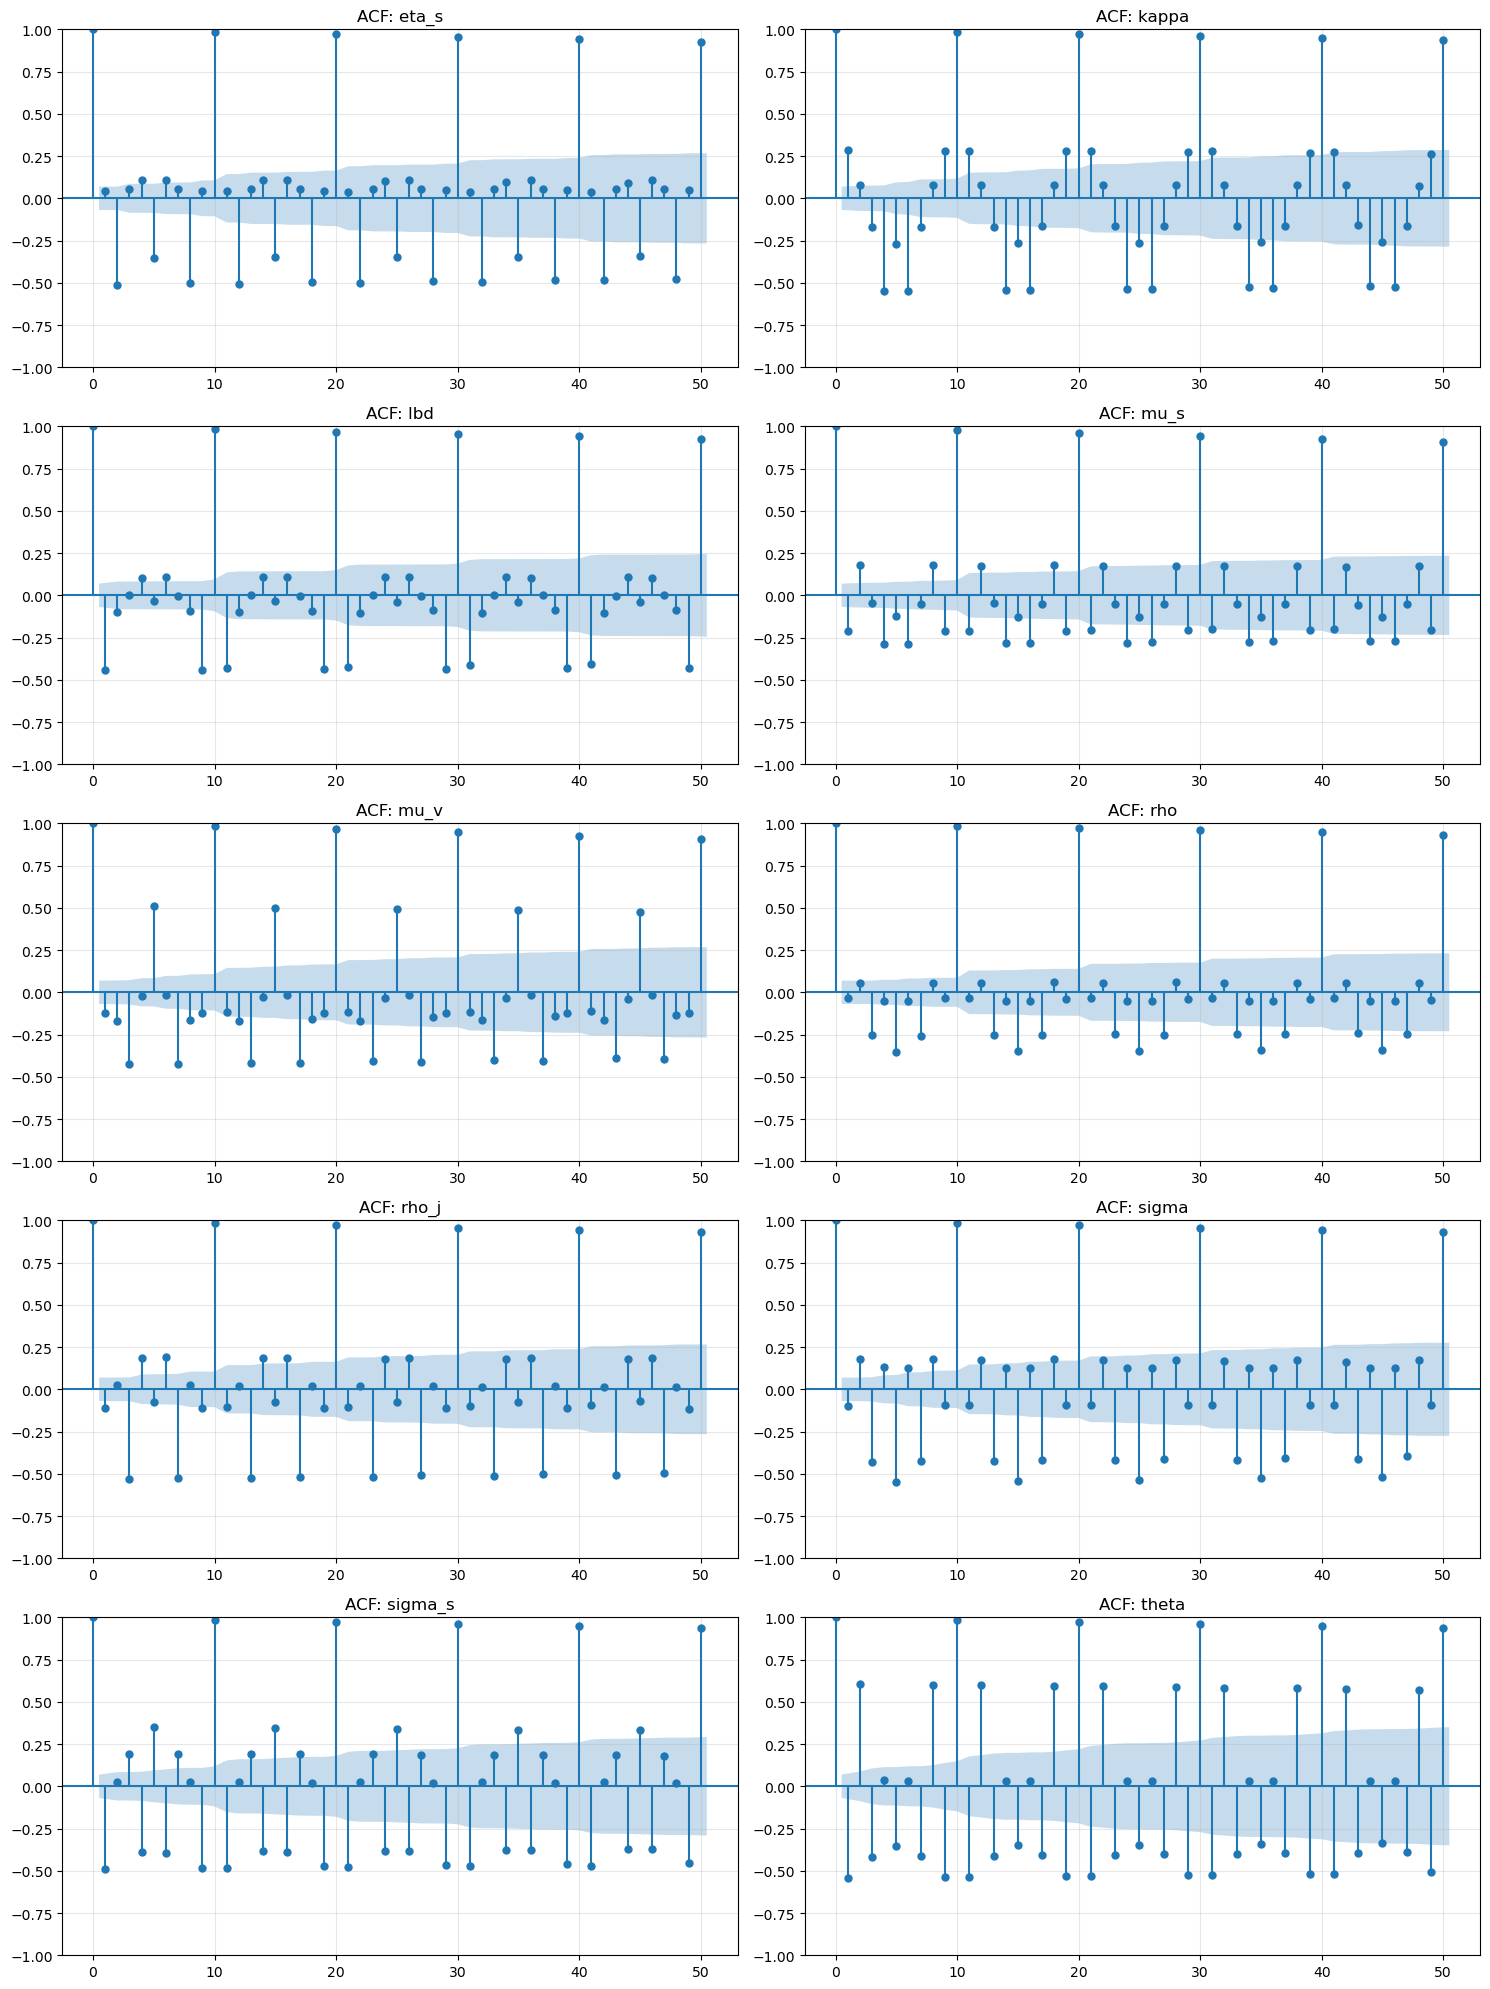

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
params = df_omcmc.columns
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()

for i, param in enumerate(params):
    plot_acf(df_omcmc[param], ax=axes[i], lags=50, title=f'ACF: {param}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

This image serves as a diagnostic confirmation of our data structure rather than model performance. Perfect correlation at Lags 0, 10, 20, 30, 40, 50. This proves that our dataset contains 10 parallel chains ($Z=10$) interlaced row-by-row.
- Lag 1 compares Chain 0 with Chain 1 (independent thus low correlation).
- Lag 10 compares Chain 0 (Cycle $t$) with Chain 0 (Cycle $t+1$).

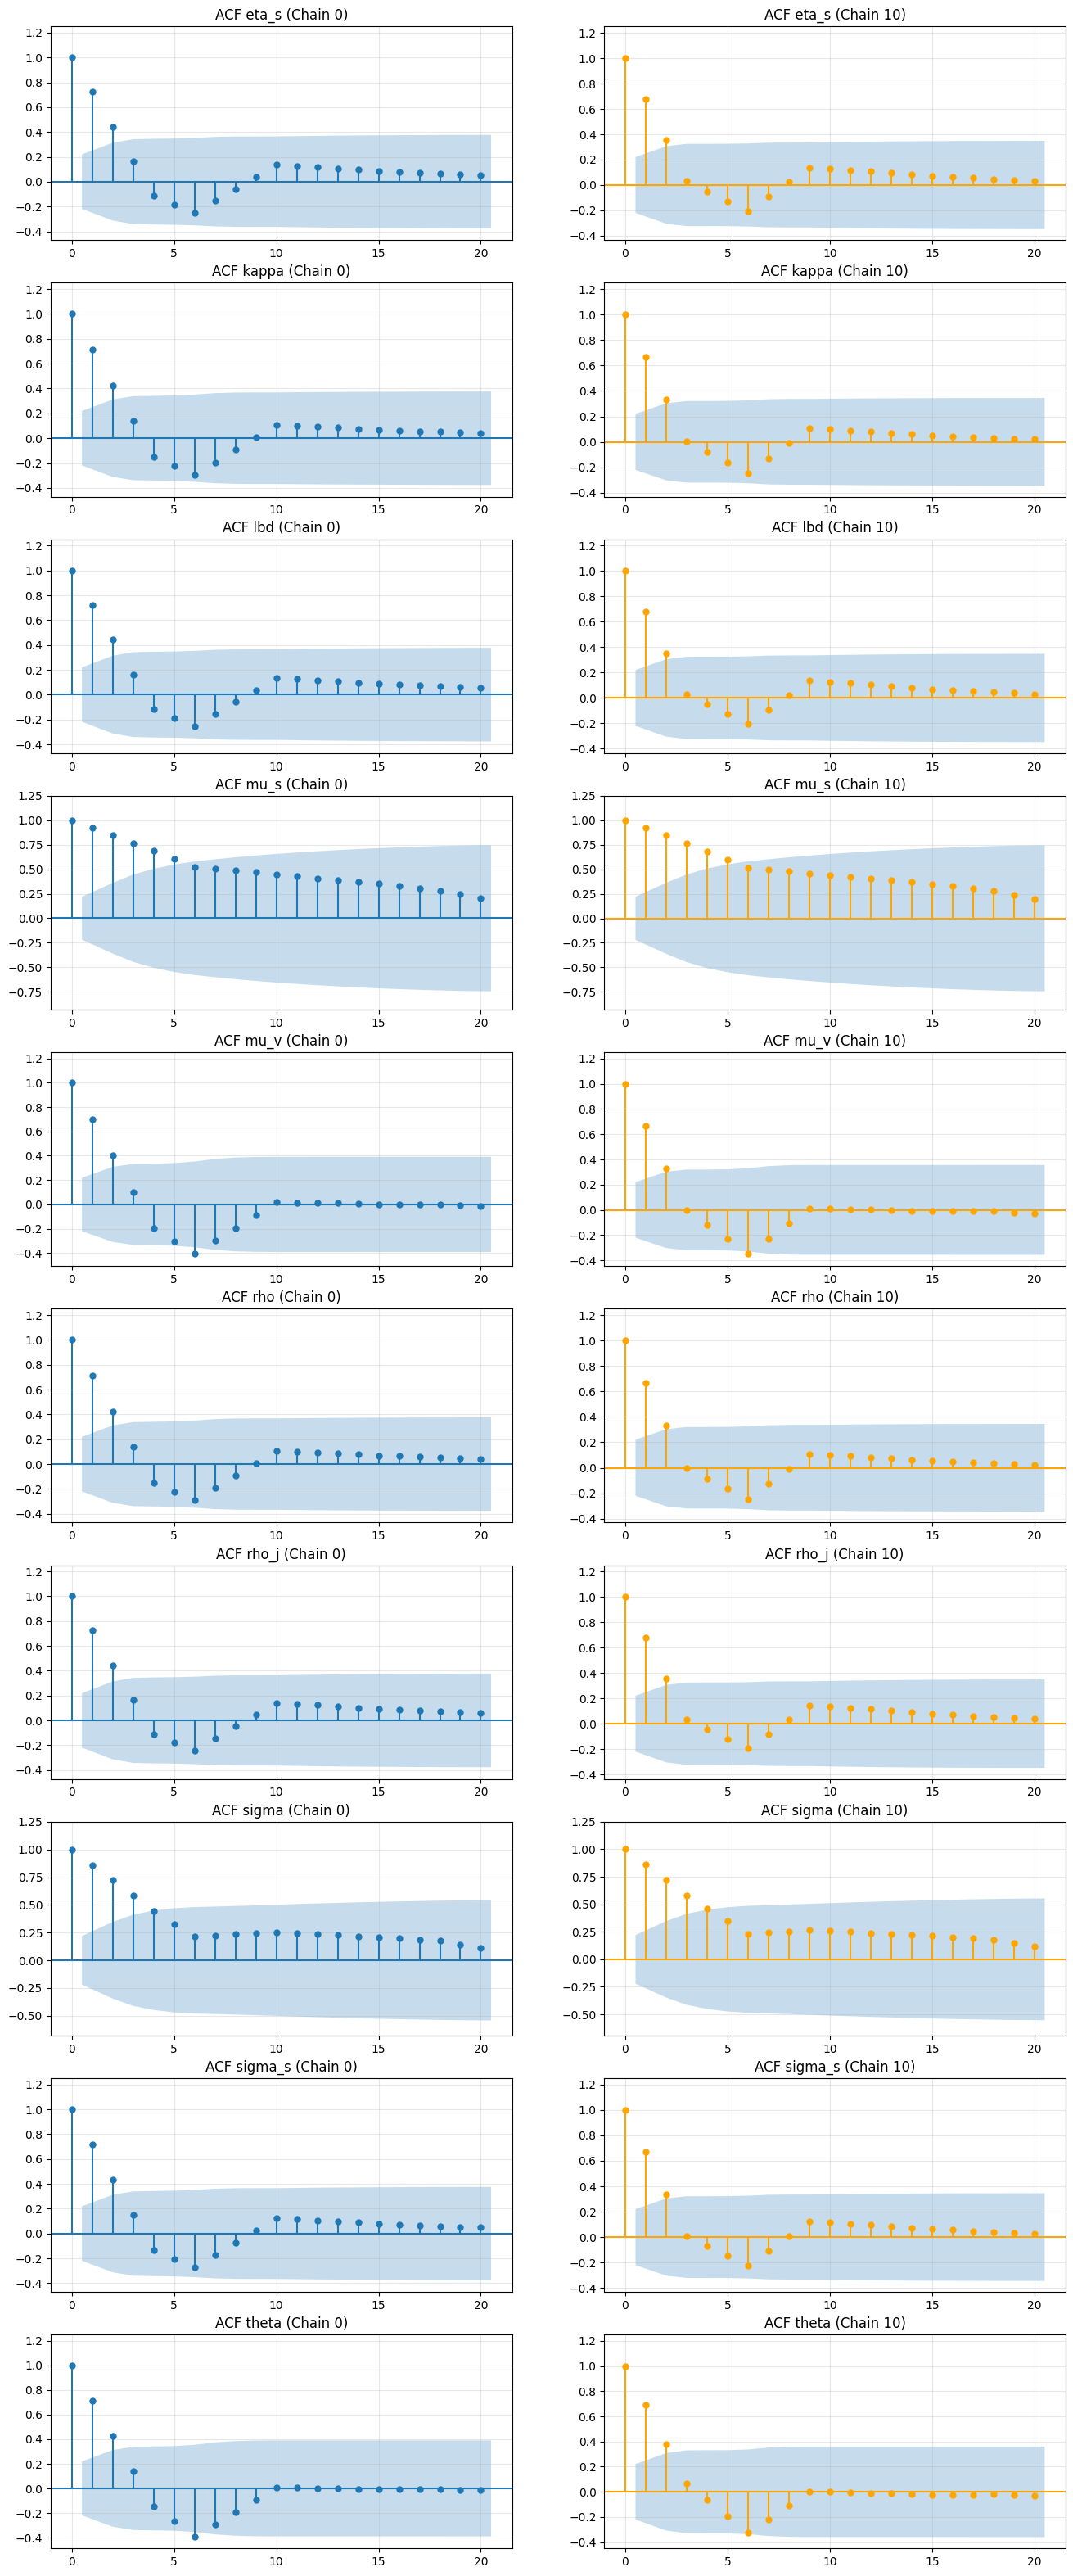

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

Z = 10
df_chain0 = df_omcmc.iloc[0::Z].copy() 
df_chain10 = df_omcmc.iloc[10::Z].copy() 

params = df_chain0.columns
fig, axes = plt.subplots(len(params), 2, figsize=(16, 4 * len(params)))

if len(params) == 1: axes = axes.reshape(1, -1)

for i, param in enumerate(params):
    plot_acf(df_chain0[param], ax=axes[i, 0], lags=20, 
             title=f'ACF {param} (Chain 0)', auto_ylims=True)
    axes[i, 0].grid(True, alpha=0.3)
    
    plot_acf(df_chain10[param], ax=axes[i, 1], lags=20, 
             title=f'ACF {param} (Chain 10)', auto_ylims=True, color='orange', vlines_kwargs={"colors": 'orange'})
    axes[i, 1].grid(True, alpha=0.3)

plt.show()


By unfolding the chains, we see the true mixing efficiency of our algorithm.

For the most complex parameters, the autocorrelation drops to zero very quickly (within 5-10 lags). This is a strong result for a high-dimensional model like SVCJ.
* **`kappa` & `theta`:** Rapid decay indicates the algorithm has successfully pinned down the mean-reversion dynamics.
* **`eta_s` (Jump Size) & `rho_j`:** Jump parameters are notoriously difficult to estimate. The fact that their ACF drops fast suggests the "Differential Evolution" step in our O-MCMC is effectively proposing good jump configurations.

However:
* **`mu_s` (Drift):** This parameter shows very slow decay (high persistence). Indeed, separating the constant drift from the stochastic volatility trend is difficult without very long time series.
* **`sigma` (Vol-of-Vol):** The ACF stays positive longer than others. This suggests the sampler struggles slightly to distinguish between high volatility (high $V_t$) and high variance of volatility (high $\sigma$).

Comparing **Chain 0** and **Chain 10**: The patterns are remarkably similar. The population has not split into different modes. These two chains are exploring the same high-probability region and experiencing the same mixing geometry.

In [44]:
from statsmodels.tsa.stattools import acf

In [ ]:
def compute_diagnostics(omcmc_obj, burnin_ratio=0.2):
    # Retrieve full history
    df = pd.DataFrame(omcmc_obj.history)
    
    # Calculate burn-in in terms of cycles
    n_cycles = df['chain_id'].value_counts().iloc[0]
    burnin = int(n_cycles * burnin_ratio)
    
    # Parameters to analyze
    params = [c for c in df.columns if c not in ['chain_id', 'iter']]
    
    results = []
    
    for param in params:
        chains_data = []
        for i in range(omcmc_obj.Z):
            # Take data from chain i, after burn-in
            chain_vals = df[df['chain_id'] == i][param].values[burnin:]
            chains_data.append(chain_vals)
        
        chains = np.array(chains_data)
        
        # Global Mean and Global Std (Posterior Uncertainty)
        mean_val = np.mean(chains)
        std_val = np.std(chains)
        
        # Gelman-Rubin (R-hat)
        N = chains.shape[1] 
        M = chains.shape[0]
        
        # Within-chain variances
        var_within = np.var(chains, axis=1, ddof=1)
        W = np.mean(var_within)
        
        # Variance between chain means
        chain_means = np.mean(chains, axis=1)
        B = N * np.var(chain_means, ddof=1)
        
        # Estimated total variance
        var_theta = (1 - 1/N) * W + (1/N) * B
        
        # R-hat
        r_hat = np.sqrt(var_theta / W)
        
        # Effective Sample Size (ESS)
        # Calculate ESS for each chain and sum them up
        ess_total = 0
        for i in range(M):
            rho = acf(chains[i], nlags=min(N//2, 100), fft=True)
            # Simple formula: ESS = N / (1 + 2 * sum(rho))
            sums_rho = 0
            for r in rho[1:]: # exclude lag 0 which is 1
                if r < 0.05: break # Cut off when correlation vanishes
                sums_rho += r
            
            ess_chain = N / (1 + 2 * sums_rho)
            ess_total += ess_chain
            
        # Monte Carlo Standard Error (MCSE)
        mcse = std_val / np.sqrt(ess_total)
        
        results.append({
            'Parameter': param,
            'Mean': mean_val,
            'Std (Uncertainty)': std_val,
            'MCSE (Est. Error)': mcse,
            'ESS (Effective Size)': int(ess_total),
            'R-hat (Converg.)': r_hat
        })
        
    return pd.DataFrame(results).set_index('Parameter')

# Run analysis
df_diag = compute_diagnostics(omcmc, burnin_ratio=0.2)

# Display with formatting
print("Convergence Diagnostics and Estimator Variance (O-MCMC):")
print("-" * 80)
print(df_diag.round(4))

Convergence Diagnostics and Estimator Variance (O-MCMC):
--------------------------------------------------------------------------------
             Mean  Std (Uncertainty)  MCSE (Est. Error)  ESS (Effective Size)  \
Parameter                                                                       
eta_s      2.0460             1.6279             0.1015                   256   
kappa      5.1230             2.7891             0.1624                   294   
lbd        1.2815             0.6430             0.0386                   277   
mu_s      -0.0521             0.0501             0.0033                   234   
mu_v       0.1367             0.0672             0.0046                   210   
rho       -0.5751             0.1384             0.0084                   270   
rho_j     -0.4076             0.2714             0.0163                   277   
sigma      0.4714             0.2194             0.0132                   277   
sigma_s    0.1155             0.0538             0.0



The diagnostic table reveals that while the algorithm has explored the parameter space, the population of chains has failed to converge to a unified posterior distribution. The results should be interpreted with extreme caution. A valid MCMC simulation requires $\hat{R}< 1.1$ to claim convergence. But all parameters show massive $\hat{R}$ values, ranging from 3.0 to 13.9.

The standard deviations (`Std`) are extremely high relative to the means, confirming the lack of consensus among chains:
* **`kappa` (Mean Reversion):** Mean $\approx 5.12$, but Std $\approx 2.79$. The model is unsure if volatility reverts slowly or extremely fast.
* **`sigma` (Vol-of-Vol):** Mean $\approx 0.47$, Std $\approx 0.22$. This is a huge range for volatility of volatility.

ESS values are very low (~200–300) compared to the likely total iterations. The chains are highly autocorrelated.

Despite the convergence failure, the mean values of the population are remarkably consistent with financial literature for SVCJ models:
* **`rho` (-0.575):** Correctly captures the leverage effect (negative correlation between returns and vol).
* **`kappa` (5.12):** High mean reversion is typical for stochastic volatility models fitting crash data.
* **`theta` (0.0375):** Implies $\sqrt{0.0375} \approx 19.3\%$ annualized volatility, which is a very realistic long-term average for the S&P 500.

The algorithm is finding the right neighborhood (the means are realistic), but the chains are getting stuck in local modes. The likelihood variance is too high. The chains accept a "lucky" particle estimate and then cannot move. The number of particles must increase a lot to lower the estimator variance and allow the chains to mix.

Optimal parameters used:
{'eta_s': np.float64(0.6786558540873032), 'kappa': np.float64(9.209656500596273), 'lbd': np.float64(2.6194184572021655), 'mu_s': np.float64(-3.25910717917417e-05), 'mu_v': np.float64(0.18646688207261033), 'rho': np.float64(-0.3499176463574141), 'rho_j': np.float64(-0.8239656016827094), 'sigma': np.float64(0.5204305344955754), 'sigma_s': np.float64(0.19448112502536774), 'theta': np.float64(0.023990459064026266)}


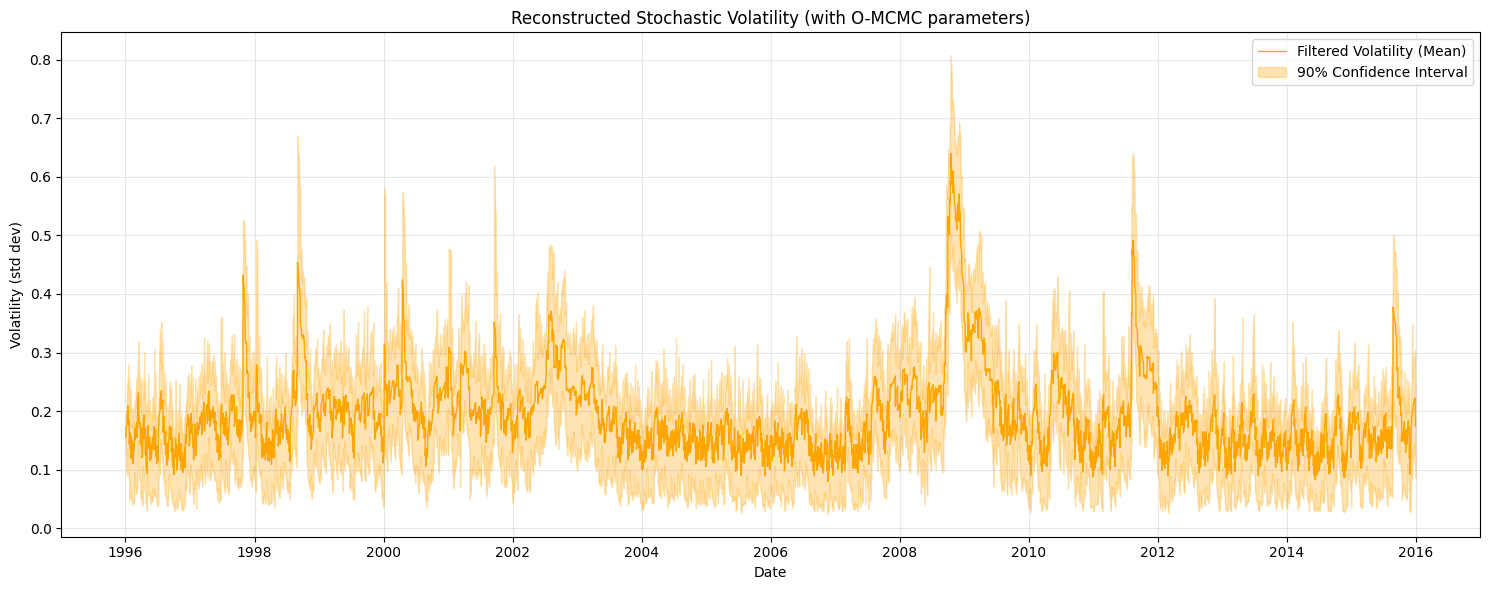

In [ ]:
SVCJ_Frozen = partial(SVCJ_Model, r_vec=r_vector, dt=1/252.0, **theta_omcmc)

# Retrieve the best parameters found by O-MCMC
# (We take the last value of the first chain)
best_theta_struct = omcmc.chains[0].chain.theta[-1]

# Conversion to dictionary for the model
theta_dict = {k: best_theta_struct[k] for k in best_theta_struct.dtype.names}

print("Optimal parameters used:")
print(theta_dict)

# Recreate the model WITH these parameters
model_optimal = SVCJ_Frozen(**theta_dict)

# Run a single filter to retrieve history
fk = ssm.Bootstrap(ssm=model_optimal, data=data_y)
pf = particles.SMC(fk=fk, N=2000, store_history=True) 
pf.run()

# Now we have access to pf.hist to plot volatility
# Variance is the 1st state variable (index 0)
# Calculate mean and quantiles of particles
filtered_vol = [np.mean(x[:, 0]) for x in pf.hist.X] 

filtered_vol_low = [np.percentile(x[:, 0], 5) for x in pf.hist.X]
filtered_vol_high = [np.percentile(x[:, 0], 95) for x in pf.hist.X]

import matplotlib.dates as mdates


import matplotlib.dates as mdates
plt.figure(figsize=(15, 6))

dates_vec=data_SP500.index[-len(filtered_vol):]  
plt.plot(dates_vec, np.sqrt(filtered_vol), label='Filtered Volatility (Mean)', color='orange', lw=1)

plt.fill_between(dates_vec, 
                 np.sqrt(filtered_vol_low), 
                 np.sqrt(filtered_vol_high), 
                 color='orange', alpha=0.3, label='90% Confidence Interval')

plt.title("Reconstructed Stochastic Volatility (with O-MCMC parameters)")
plt.ylabel("Volatility (std dev)")
plt.xlabel("Date")

plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()